In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

In [2]:
def black(f, vol, k, tau, is_call):
    stdev = vol * np.sqrt(tau)
    dp = np.log(f / k) / stdev + 0.5 * stdev
    dm = np.log(f / k) / stdev - 0.5 * stdev
    w = 1 if is_call else -1
    return w * (f * norm.cdf(w * dp) - k * norm.cdf(w * dm))

In [3]:
def make_dataset(num_of_data):
    fs = []
    vols = []
    ks = []
    taus = []
    pvs = []


    np.random.seed(1)
    for i in range(num_of_data):
        f = 100 * np.exp(np.random.randn() - 0.5)
        vol = 0.0001 + 0.9999 * np.random.random()
        k = 100 * np.exp(np.random.randn() - 0.5)
        tau = np.random.exponential(1.0)
        is_call = True
        pv = black(f, vol, k, tau, is_call)

        fs += [f]
        vols += [vol]
        ks += [k]
        taus += [tau]
        pvs += [pv]
    
    return pd.DataFrame(
        data={'fwd': fs, 'vol': vols, 'strike': ks, 'expiry': taus, 'pv': pvs}, 
        columns=['fwd', 'vol', 'strike', 'expiry', 'pv'])

In [4]:
num_of_data = 1000000
train_dataset = make_dataset(num_of_data)
#train_dataset.tail()

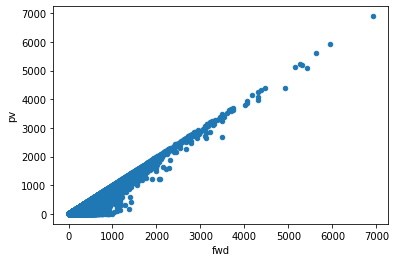

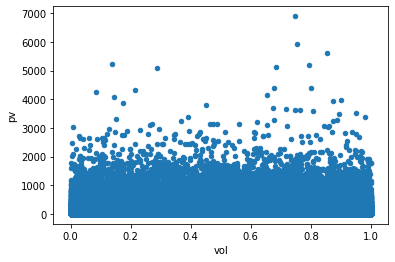

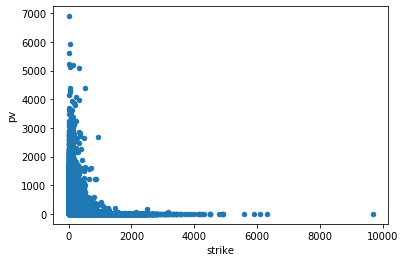

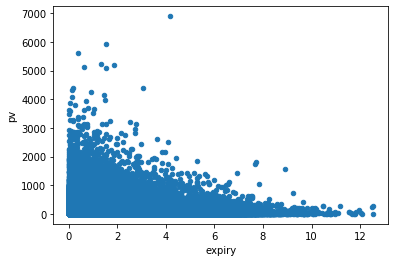

In [5]:
train_dataset.plot(kind='scatter', x='fwd', y='pv')
train_dataset.plot(kind='scatter', x='vol', y='pv')
train_dataset.plot(kind='scatter', x='strike', y='pv')
train_dataset.plot(kind='scatter', x='expiry', y='pv')

In [6]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
print(train_stats['mean'].pv)
print(train_stats['std'].pv)

55.04410754658603
119.99134465147839


In [7]:
def normalize(dataset):
    return (dataset - train_stats['mean']) / train_stats['std']

In [8]:
norm_train_dataset = normalize(train_dataset)

In [9]:
train_labels = norm_train_dataset.pop('pv')

In [10]:
def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation=tf.nn.relu, input_shape=[len(norm_train_dataset.keys())]), 
        layers.Dense(128, activation=tf.nn.relu), 
        layers.Dense(128, activation=tf.nn.relu), 
        layers.Dense(128, activation=tf.nn.relu), 
        layers.Dense(1),
    ])
    
    optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    
    model.compile(loss='mean_squared_error', 
                 optimizer=optimizer, 
                 metrics=['mean_squared_error'])
    
    return model

In [11]:
model = build_model()

W0702 08:08:57.200935  8868 deprecation.py:506] From C:\Users\peace\Anaconda3\envs\tensorflow16\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               640       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 50,305
Trainable params: 50,305
Non-trainable params: 0
_________________________________________________________________


In [13]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

early_stopping = keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=0, verbose=0, mode='auto')
history = model.fit(norm_train_dataset, train_labels, epochs=1000, validation_split=0.2, verbose=0, callbacks=[PrintDot(), early_stopping])


........................

In [14]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_squared_error,val_loss,val_mean_squared_error,epoch
19,0.000049,0.000049,0.000047,0.000047,19
20,0.000048,0.000048,0.000042,0.000042,20
21,0.000047,0.000047,0.000041,0.000041,21
22,0.000045,0.000045,0.000046,0.000046,22
23,0.000045,0.000045,0.000039,0.000039,23


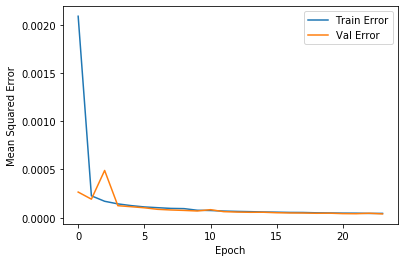

In [15]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'], label='Val Error')
    plt.legend()
    
plot_history(history)

In [8]:
cur_dir = os.getcwd()

In [ ]:
#model.save(cur_dir + r"\work\bs_ml_model.h5")

In [9]:
model = keras.models.load_model(cur_dir + r"\work\bs_ml_model.h5")

W0703 00:01:17.334127 14572 deprecation.py:506] From C:\Users\peace\Anaconda3\envs\tensorflow16\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0703 00:01:17.337130 14572 deprecation.py:506] From C:\Users\peace\Anaconda3\envs\tensorflow16\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0703 00:01:17.339112 14572 deprecation.py:506] From C:\Users\peace\Anaconda3\envs\tensorflow16\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tenso

In [33]:
def make_test_delta(num_of_test_data, lb, ub, vol, strike, expiry, is_call):
    fs = []
    vols = []
    ks = []
    taus = []
    pvs = []

    for i in range(1, num_of_test_data + 1):
        f = (ub - lb) * 1.0 * i / num_of_test_data
        pv = black(f, vol, strike, expiry, is_call)

        fs += [f]
        vols += [vol]
        ks += [strike]
        taus += [expiry]
        pvs += [pv]
    
    return pd.DataFrame(
        data={'fwd': fs, 'vol': vols, 'strike': ks, 'expiry': taus, 'pv': pvs}, 
        columns=['fwd', 'vol', 'strike', 'expiry', 'pv'])

def make_test_vega(num_of_test_data, lb, ub, fwd, strike, expiry, is_call):
    fs = []
    vols = []
    ks = []
    taus = []
    pvs = []

    for i in range(1, num_of_test_data + 1):
        vol = (ub - lb) * 1.0 * i / num_of_test_data
        pv = black(fwd, vol, strike, expiry, is_call)

        fs += [fwd]
        vols += [vol]
        ks += [strike]
        taus += [expiry]
        pvs += [pv]
    
    return pd.DataFrame(
        data={'fwd': fs, 'vol': vols, 'strike': ks, 'expiry': taus, 'pv': pvs}, 
        columns=['fwd', 'vol', 'strike', 'expiry', 'pv'])

In [34]:
def append_pv_ml(test_dataset):
    norm_test_dataset = normalize(test_dataset)
    norm_test_labels = norm_test_dataset.pop('pv')
    norm_test_predictions = model.predict(norm_test_dataset).flatten()
    test_predictions = pd.Series(norm_test_predictions * train_stats['std'].pv + train_stats['mean'].pv)
    test_dataset['pv_ml'] = test_predictions

In [35]:
def display_result(test_dataset, key):
    plt.figure()
    plt.xlabel(key)
    plt.ylabel('pv')
    plt.plot(test_dataset[key], test_dataset['pv'], label='PV')
    plt.plot(test_dataset[key], test_dataset['pv_ml'], label='PV(ML)')
    plt.legend()

In [36]:
num_of_test_data = 199

In [37]:
strike = 100.0
expiry = 1.0
is_call = True

test_dataset_1y_atm_delta = make_test_delta(num_of_test_data, 1, 200, 0.3, strike, expiry, is_call)
test_dataset_1y_atm_vega = make_test_vega(num_of_test_data, 0.005, 1.0, 100, strike, expiry, is_call)

In [38]:
strike = 80.0
expiry = 1.0
is_call = True

test_dataset_1y_itm_delta = make_test_delta(num_of_test_data, 1, 200, 0.3, strike, expiry, is_call)
test_dataset_1y_itm_vega = make_test_vega(num_of_test_data, 0.005, 1.0, 100, strike, expiry, is_call)

In [39]:
strike = 120.0
expiry = 1.0
is_call = True

test_dataset_1y_otm_delta = make_test_delta(num_of_test_data, 1, 200, 0.3, strike, expiry, is_call)
test_dataset_1y_otm_vega = make_test_vega(num_of_test_data, 0.005, 1.0, 100, strike, expiry, is_call)

In [40]:
strike = 100.0
expiry = 5.0
is_call = True

test_dataset_5y_atm_delta = make_test_delta(num_of_test_data, 1, 200, 0.3, strike, expiry, is_call)
test_dataset_5y_atm_vega = make_test_vega(num_of_test_data, 0.005, 1.0, 100, strike, expiry, is_call)

In [41]:
strike = 80.0
expiry = 5.0
is_call = True

test_dataset_5y_itm_delta = make_test_delta(num_of_test_data, 1, 200, 0.3, strike, expiry, is_call)
test_dataset_5y_itm_vega = make_test_vega(num_of_test_data, 0.005, 1.0, 100, strike, expiry, is_call)

In [42]:
strike = 120.0
expiry = 5.0
is_call = True

test_dataset_5y_otm_delta = make_test_delta(num_of_test_data, 1, 200, 0.3, strike, expiry, is_call)
test_dataset_5y_otm_vega = make_test_vega(num_of_test_data, 0.005, 1.0, 100, strike, expiry, is_call)

In [43]:
strike = 100.0
expiry = 0.1
is_call = True

test_dataset_1m_atm_delta = make_test_delta(num_of_test_data, 1, 200, 0.3, strike, expiry, is_call)
test_dataset_1m_atm_vega = make_test_vega(num_of_test_data, 0.005, 1.0, 100, strike, expiry, is_call)

In [44]:
strike = 80.0
expiry = 0.1
is_call = True

test_dataset_1m_itm_delta = make_test_delta(num_of_test_data, 1, 200, 0.3, strike, expiry, is_call)
test_dataset_1m_itm_vega = make_test_vega(num_of_test_data, 0.005, 1.0, 100, strike, expiry, is_call)

In [45]:
strike = 120.0
expiry = 0.1
is_call = True

test_dataset_1m_otm_delta = make_test_delta(num_of_test_data, 1, 200, 0.3, strike, expiry, is_call)
test_dataset_1m_otm_vega = make_test_vega(num_of_test_data, 0.005, 1.0, 100, strike, expiry, is_call)

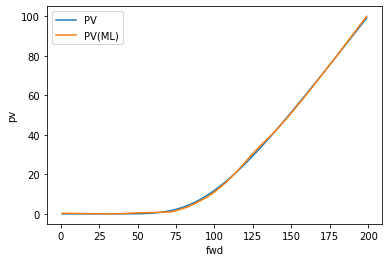

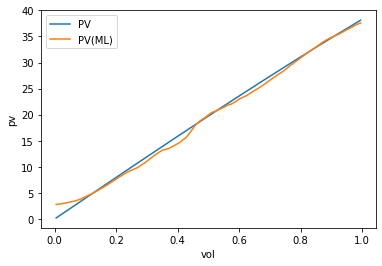

In [46]:
append_pv_ml(test_dataset_1y_atm_delta)
append_pv_ml(test_dataset_1y_atm_vega)
display_result(test_dataset_1y_atm_delta, 'fwd')
display_result(test_dataset_1y_atm_vega, 'vol')

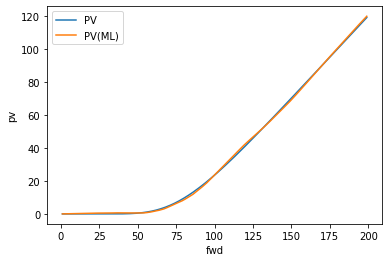

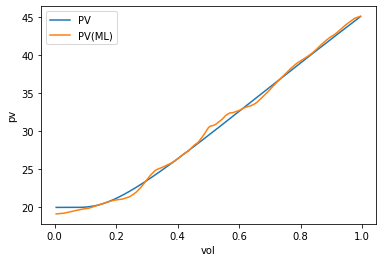

In [47]:
append_pv_ml(test_dataset_1y_itm_delta)
append_pv_ml(test_dataset_1y_itm_vega)
display_result(test_dataset_1y_itm_delta, 'fwd')
display_result(test_dataset_1y_itm_vega, 'vol')

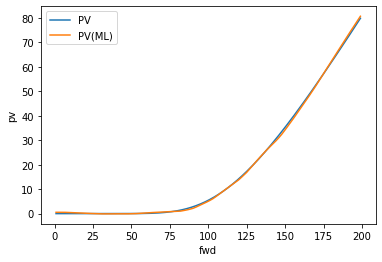

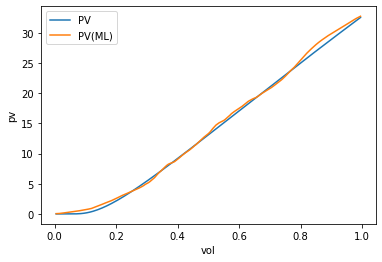

In [48]:
append_pv_ml(test_dataset_1y_otm_delta)
append_pv_ml(test_dataset_1y_otm_vega)
display_result(test_dataset_1y_otm_delta, 'fwd')
display_result(test_dataset_1y_otm_vega, 'vol')

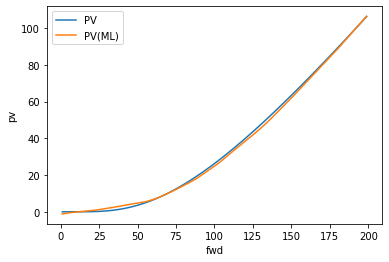

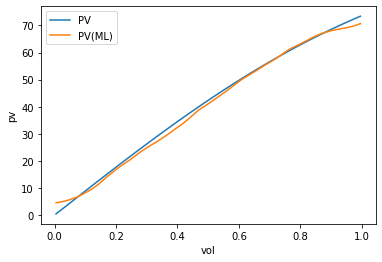

In [49]:
append_pv_ml(test_dataset_5y_atm_delta)
append_pv_ml(test_dataset_5y_atm_vega)
display_result(test_dataset_5y_atm_delta, 'fwd')
display_result(test_dataset_5y_atm_vega, 'vol')

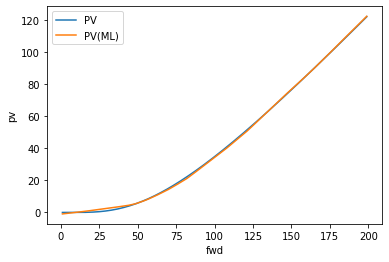

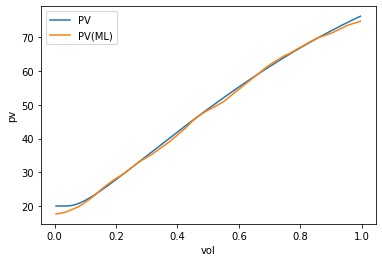

In [50]:
append_pv_ml(test_dataset_5y_itm_delta)
append_pv_ml(test_dataset_5y_itm_vega)
display_result(test_dataset_5y_itm_delta, 'fwd')
display_result(test_dataset_5y_itm_vega, 'vol')

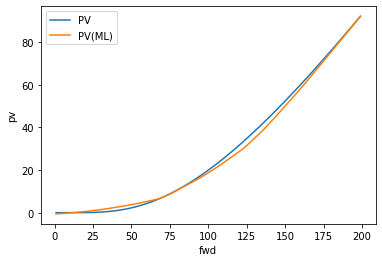

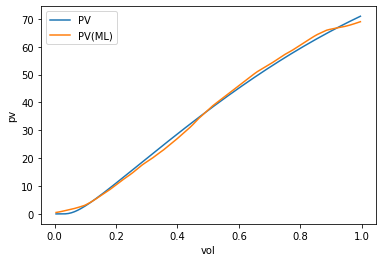

In [51]:
append_pv_ml(test_dataset_5y_otm_delta)
append_pv_ml(test_dataset_5y_otm_vega)
display_result(test_dataset_5y_otm_delta, 'fwd')
display_result(test_dataset_5y_otm_vega, 'vol')

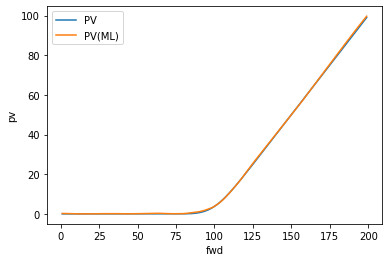

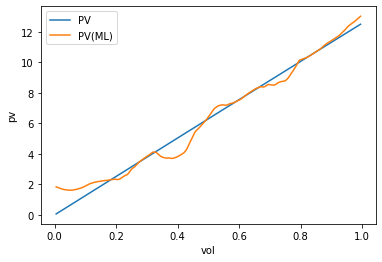

In [52]:
append_pv_ml(test_dataset_1m_atm_delta)
append_pv_ml(test_dataset_1m_atm_vega)
display_result(test_dataset_1m_atm_delta, 'fwd')
display_result(test_dataset_1m_atm_vega, 'vol')

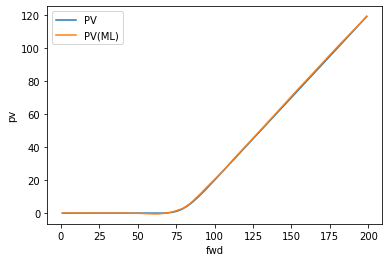

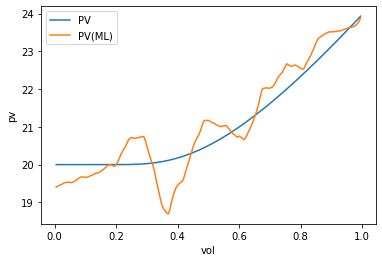

In [53]:
append_pv_ml(test_dataset_1m_itm_delta)
append_pv_ml(test_dataset_1m_itm_vega)
display_result(test_dataset_1m_itm_delta, 'fwd')
display_result(test_dataset_1m_itm_vega, 'vol')

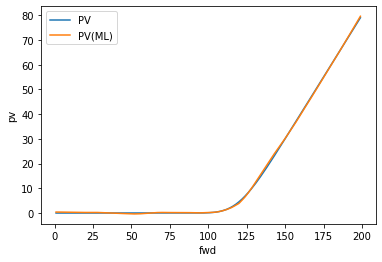

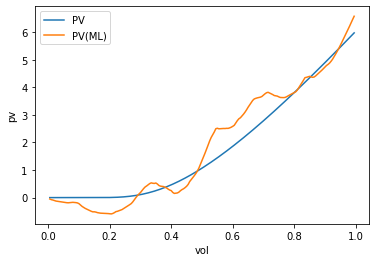

In [54]:
append_pv_ml(test_dataset_1m_otm_delta)
append_pv_ml(test_dataset_1m_otm_vega)
display_result(test_dataset_1m_otm_delta, 'fwd')
display_result(test_dataset_1m_otm_vega, 'vol')

In [55]:
test_dataset_1y_atm_delta.to_csv(cur_dir + r"\work\1y_atm_delta.csv")
test_dataset_1y_atm_vega.to_csv(cur_dir + r"\work\1y_atm_vega.csv")
test_dataset_1y_itm_delta.to_csv(cur_dir + r"\work\1y_itm_delta.csv")
test_dataset_1y_itm_vega.to_csv(cur_dir + r"\work\1y_itm_vega.csv")
test_dataset_1y_otm_delta.to_csv(cur_dir + r"\work\1y_otm_delta.csv")
test_dataset_1y_otm_vega.to_csv(cur_dir + r"\work\1y_otm_vega.csv")
test_dataset_5y_atm_delta.to_csv(cur_dir + r"\work\5y_atm_delta.csv")
test_dataset_5y_atm_vega.to_csv(cur_dir + r"\work\5y_atm_vega.csv")
test_dataset_5y_itm_delta.to_csv(cur_dir + r"\work\5y_itm_delta.csv")
test_dataset_5y_itm_vega.to_csv(cur_dir + r"\work\5y_itm_vega.csv")
test_dataset_5y_otm_delta.to_csv(cur_dir + r"\work\5y_otm_delta.csv")
test_dataset_5y_otm_vega.to_csv(cur_dir + r"\work\5y_otm_vega.csv")
test_dataset_1m_atm_delta.to_csv(cur_dir + r"\work\1m_atm_delta.csv")
test_dataset_1m_atm_vega.to_csv(cur_dir + r"\work\1m_atm_vega.csv")
test_dataset_1m_itm_delta.to_csv(cur_dir + r"\work\1m_itm_delta.csv")
test_dataset_1m_itm_vega.to_csv(cur_dir + r"\work\1m_itm_vega.csv")
test_dataset_1m_otm_delta.to_csv(cur_dir + r"\work\1m_otm_delta.csv")
test_dataset_1m_otm_vega.to_csv(cur_dir + r"\work\1m_otm_vega.csv")